<a href="https://colab.research.google.com/github/tbilach13/Analysis_Police_Killings/blob/master/Bilach__Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Police Killings

The present analysis investigates the contextual factors affecting police use-of-force decisions in the field. I downloaded data from the [The Guardian's](https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/about-the-counted) webpage, which includes all "reported" police killings in 2015. They call this accumulation of police killings [The Counted](https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/the-counted-police-killings-us-database). I will use this dataset to investigate the following:

1. The demographic composition of decedents;
2. The threat-level impose upon officers at the time of the suspect's death;
3. The agencies and states with the most police shootings per capita.

First, I imported the relevant modules/packages to facilitate this analysis.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/the-counted-2015.csv", encoding = "ISO-8859-1")
deaths = df.copy()

[The Counted](https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/the-counted-police-killings-us-database) dataset catalogued all "reported" police killings in 2015. There are 1,146 rows and 13 columns. Each row represents a unique police killing. Additional variables were collected to shed light on the demographic composition of those killed by the police and the threat-level posed to the officer before lethal force was used. Below is the first ten rows and a subset of the columns. 

In [52]:
deaths[['name', 'age', 'gender', 'raceethnicity', 'month', 'city', 'state', 'armed']].head(10)

,name,age,gender,raceethnicity,month,city,state,armed
0,Matthew Ajibade,22,Male,Black,January,Savannah,GA,No
1,Lewis Lembke,47,Male,White,January,Aloha,OR,Firearm
2,Michael Kocher Jr,19,Male,White,January,Kaumakani,HI,No
3,John Quintero,23,Male,Hispanic/Latino,January,Wichita,KS,No
4,Tim Elliott,53,Male,Asian/Pacific Islander,January,Shelton,WA,Firearm
5,Matthew Hoffman,32,Male,White,January,San Francisco,CA,Non-lethal firearm
6,Kenneth Buck,22,Male,Hispanic/Latino,January,Chandler,AZ,Firearm
7,Michael Rodriguez,39,Male,Hispanic/Latino,January,Evans,CO,Other
8,Patrick Wetter,25,Male,White,January,Stockton,CA,Knife
9,Brian Pickett,26,Male,Black,January,Los Angeles,CA,No


### Data Cleaning/Preparation

In addition to renaming the relevant variables (e.g., gender, race/ehtnicity, agency name, etc.), I also recoded "race/ethnicity" to capture the four most frequent racial/ethic categories recorded (i.e., White, Black, Hispanic/Latino, and Asian/Pacific Islander). There is a category for "Other" but it represents a small proportion total reported killings per jurisdiction and per year.

In [53]:
deaths.rename(columns = {'name'                 : 'decedent_name',
                         'raceethnicity'        : 'race_ethn',
                         'streetaddress'        : 'str_add',
                         'lawenforcementagency' : 'agency_name'
                         }, inplace = True)

deaths['age'] = deaths['age'].replace('Unknown', np.nan).apply(float)

# Combining dropping the 'non-conforming' category

def flag_non_conforming(df):
  if df['gender'] == 'Non-conforming':
    return np.nan
  else:
    return df['gender']

deaths['gender'] = deaths.apply(flag_non_conforming, axis = 1)

# Combining race/ethnic categories

def flag_comb_race_cat(df):
  if (df['race_ethn'] == 'Arab-American' or df['race_ethn'] == 'Native American' or df['race_ethn'] == 'Other' or df['race_ethn'] == 'Unknown'):
    return 'Other'
  else:
    return df['race_ethn']

deaths['race_ethn'] = deaths.apply(flag_comb_race_cat, axis = 1)
deaths['race_ethn'] = deaths['race_ethn'].astype('category')
deaths['race_ethn'].cat.reorder_categories(['White', 
                                            'Black', 
                                            'Hispanic/Latino', 
                                            'Asian/Pacific Islander',
                                            'Other'], inplace = True)

deaths['month'] = deaths['month'].astype('category')
deaths['month'].cat.reorder_categories(['January', 
                                        'February', 
                                        'March', 
                                        'April', 
                                        'May', 
                                        'June', 
                                        'July', 
                                        'August', 
                                        'September', 
                                        'October', 
                                        'November', 
                                        'December'], 
                                       inplace = True)
deaths['armed'].value_counts()

Firearm               554
No                    235
Knife                 152
Other                  64
Non-lethal firearm     47
Unknown                45
Vehicle                44
Disputed                5
Name: armed, dtype: int64

Next, I created a series of indicator variables to assess the different threat-levels faced by officers. For example, I wanted to assess the relative proportions of *armed suspects*. In particular, of those killing by the police, what proportion were in possession of a dangerous instrument/weapon?

In [0]:
# The suspect displays "any weapon" to the officer.

def flag_any_weapon(df):
  if (df['armed'] == 'No' or df['armed'] == 'Unknown' or df['armed'] == 'Disputed'):
    return 0
  else:
    return 1

deaths['any_weapon'] = deaths.apply(flag_any_weapon, axis = 1)

# The suspect displays a "gun (or toy gun)" to the officer.

def flag_gun(df):
  if (df['armed'] == 'Firearm' or df['armed'] == 'Non-lethal firearm'):
    return 1
  else:
    return 0

deaths['gun_displayed'] = deaths.apply(flag_gun, axis = 1)

# The suspect displays a "knife" to the officer.

def flag_knife(df):
  if (df['armed'] == 'Knife'):
    return 1
  else:
    return 0

deaths['knife_displayed'] = deaths.apply(flag_knife, axis = 1)

# The suspect tried to ram officer with vehicle.

def flag_vehicle(df):
  if (df['armed'] == 'Vehicle'):
    return 1
  else:
    return 0 

deaths['vehicle_ramming'] = deaths.apply(flag_vehicle, axis = 1)

# The suspect was "unarmed (included unknown)" at the time of death.

def flag_unarmed(df):
  if (df['armed'] == 'No' or df['armed'] == 'Unknown'):
    return 1
  else:
    return 0

deaths['unarmed'] = deaths.apply(flag_unarmed, axis = 1)

The following table is a cross-tabulation of race/ethnicity by gender. Unsurprisingly, males are overrepresented among those killed by the police. In the United States, in general, men are more likely to be arrested and/or killed by the police. 

In [55]:
deaths.dropna(subset = ['gender'])
pd.crosstab(index = deaths["race_ethn"], 
                       columns = deaths["gender"],
                       margins = True,
                       colnames = ['Gender:'],
                       rownames = ["Race/Ethnicity"])

Gender:,Female,Male,All
Race/Ethnicity,,,
White,34,550,584
Black,12,295,307
Hispanic/Latino,3,191,194
Asian/Pacific Islander,2,22,24
Other,1,35,36
All,52,1093,1145


Next, I assessed the age distribution of those killed by the police. Most of the observations cluster around individuals in their thirties. Moreover, given the right skew present in the distribution, many suspects killed by the police are much older than I suspected.

Text(0, 0.5, 'Density')

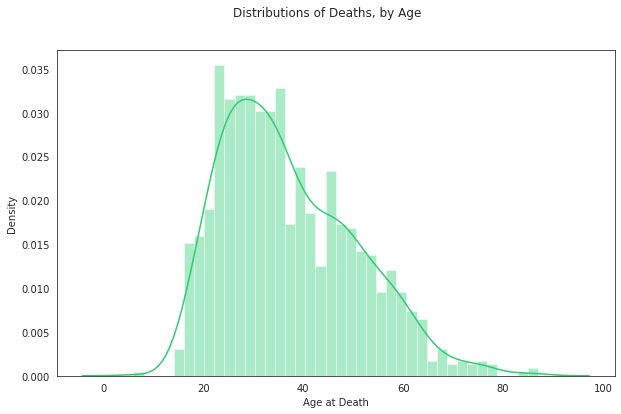

In [56]:
sns.set_style("white")
dims = (10, 6)
fig, ax = plt.subplots(figsize = (dims))
fig.suptitle('Distributions of Deaths, by Age')
sns.distplot(deaths['age'], label = deaths['gender'], bins = 40, hist = True, kde = True, color = '#2ecc71', ax = ax)
plt.xlabel("Age at Death")
plt.ylabel("Density")

Bu what about differences in age between men and women. Unsurprisingly, the distribution of females killed by the police is more uniform, but this is largely a function of their low prevalence among those stopped and/or engaged in criminal activity. The average age of those killed, for both men and women, is higher than I expected. However, there is also wider variation around the mean for men.

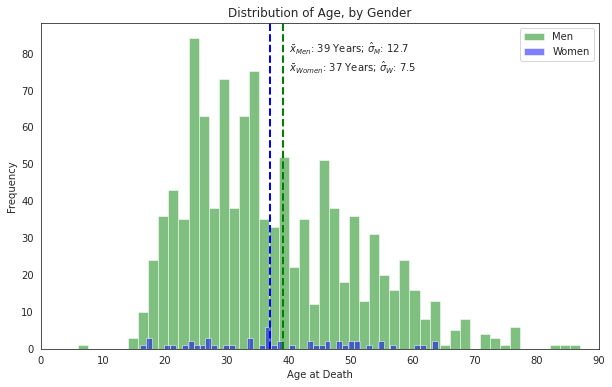

In [57]:
sns.set_style("white")
dims = (10, 6)
fig, ax = plt.subplots(figsize = (dims))
x1 = deaths.loc[deaths.gender == 'Male', 'age']
x2 = deaths.loc[deaths.gender == 'Female', 'age']
kwargs = dict(alpha = 0.5, bins = 50)
plt.hist(x1, **kwargs, color = 'g', label = 'Men')
plt.hist(x2, **kwargs, color = 'b', label = 'Women')
plt.gca().set(title = 'Distribution of Age, by Gender', ylabel = 'Frequency')
plt.axvline(39, color = 'g', linestyle = 'dashed', linewidth = 2)
plt.axvline(37, color = 'b', linestyle = 'dashed', linewidth = 2)
plt.text(40, 80, r'$\bar{x}_{Men}$: 39 Years; $\hat{\sigma}_{M}$: 12.7')
plt.text(40, 75, r'$\bar{x}_{Women}$: 37 Years; $\hat{\sigma}_{W}$: 7.5')
plt.xlabel("Age at Death")
plt.xlim(0, 90)
plt.legend()

It is also evident from the plot below that the distribution of Black males killed is less right-tail heavy. Blacks and Hispanics/Latinos tend to be younger, on average. White decedents, on average, tend to be older, irrespective of their gender.

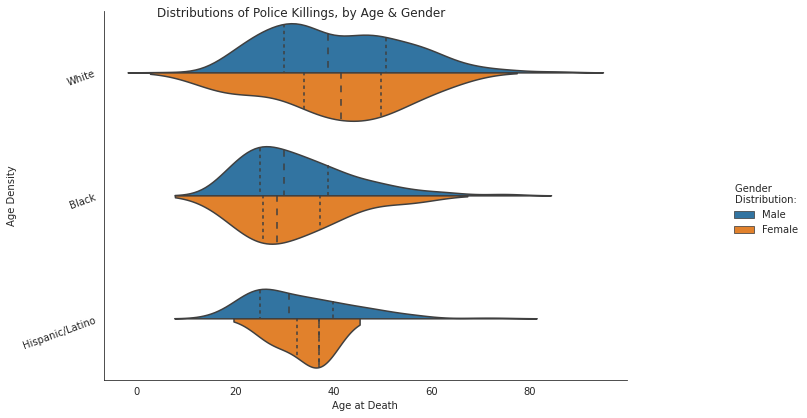

In [58]:
sns.set_style("white")
p = sns.catplot(x = "age", 
                y = "race_ethn", 
                kind = "violin", 
                hue = "gender", 
                split = True,
                order = ["White", "Black", "Hispanic/Latino"], 
                inner = "quartile", data = deaths)
p.fig.suptitle('Distributions of Police Killings, by Age & Gender')
p._legend.set_title("Gender \nDistribution:")
p.set_yticklabels(rotation = 20)
p.set(xlabel = 'Age at Death', ylabel = 'Age Density')
p.fig.set_size_inches(14, 6)

Text(0.5, 0, 'Proportion')

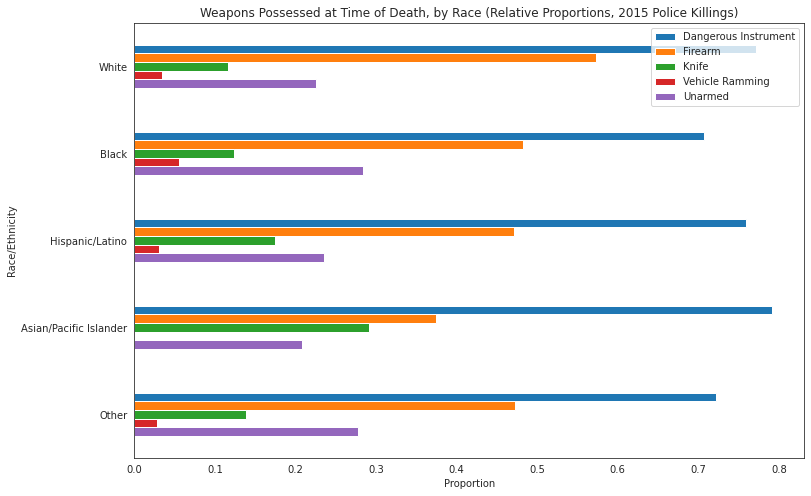

In [59]:
threat_types = deaths[["race_ethn", "any_weapon", "gun_displayed", "knife_displayed", "vehicle_ramming", "unarmed"]]

threat_types.rename(columns = {'race_ethn'       : 'Race/Ethnicity',
                               'any_weapon'      : 'Dangerous Instrument',
                               'gun_displayed'   : 'Firearm',
                               'knife_displayed' : 'Knife',
                               'vehicle_ramming' : 'Vehicle Ramming',
                               'unarmed'         : 'Unarmed'
                               }, inplace = True)

sns.set_style("white")
threat_types.groupby('Race/Ethnicity').mean().plot(kind = "barh", figsize = (12, 8)).invert_yaxis()
plt.title('Weapons Possessed at Time of Death, by Race (Relative Proportions, 2015 Police Killings)')
plt.xlabel('Proportion')

To conclude, I assess killing by agency type and by state. Below are the top ten agencies with the large number (count) of police killings. It is worth noting that most of police department on this list are embedded within large metropolitan cities with large population desities.

Text(0.5, 0, 'Total')

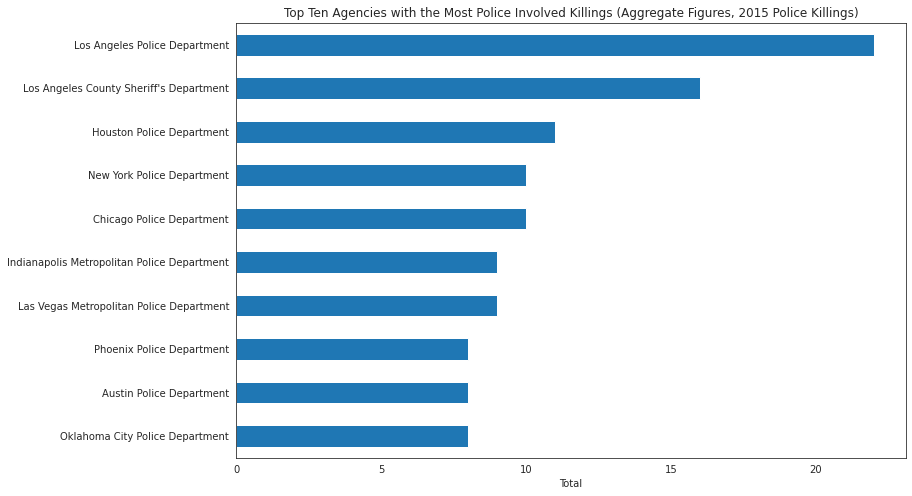

In [60]:
top_killers = deaths['agency_name'].value_counts().head(10).plot(kind = "barh", figsize = (12, 8)).invert_yaxis()
plt.title('Top Ten Agencies with the Most Police Involved Killings (Aggregate Figures, 2015 Police Killings)')
plt.xlabel('Total')

The state level "counts" show California, Texas, and Florida's counts leading country with the largest number of total reported police killings. This is largely a function of the total number of large metropolitan "cities" embedded *within* each state.

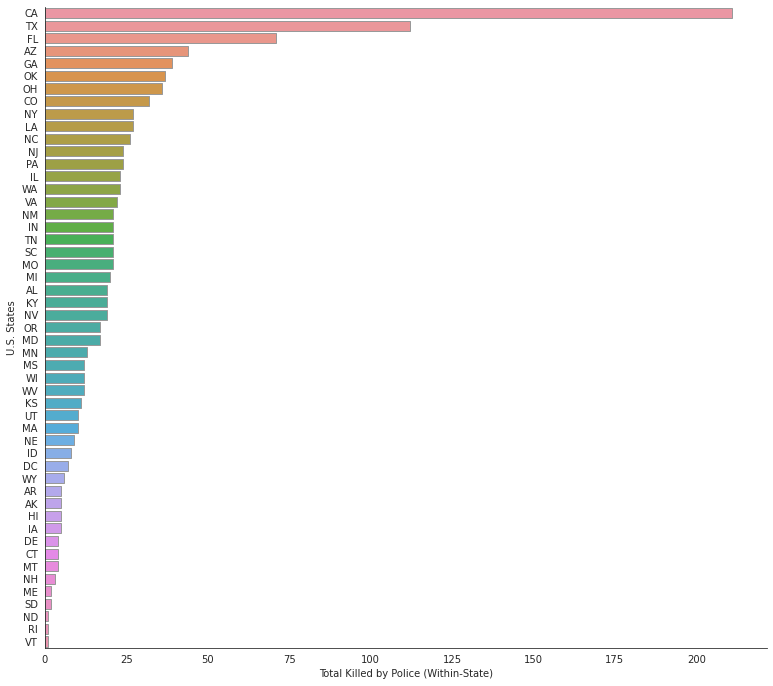

In [61]:
sns.set_style("white")
p2 = sns.catplot(y = "state", kind = "count", edgecolor = ".6", order = deaths["state"].value_counts().index, data = deaths)
p2.fig.set_size_inches(12, 10)
p2.set(xlabel = 'Total Killed by Police (Within-State)', ylabel = 'U.S. States');

In [62]:
pop = pd.read_csv('/content/drive/My Drive/Colab Notebooks/State Populations.csv')
pop.head(10)

,State,2018 Population
0,California,39776830
1,Texas,28704330
2,Florida,21312211
3,New York,19862512
4,Pennsylvania,12823989
5,Illinois,12768320
6,Ohio,11694664
7,Georgia,10545138
8,North Carolina,10390149
9,Michigan,9991177


In [0]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
    }

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

The 2015 database of police killings only includes a state abbreviation (e.g., NY). The population data frame I obtained from [kaggle.com](https://www.kaggle.com/) lists only the full state names (e.g., New York). Once I obtained a dictionary of state information, I was able to transform the state "label" to full state "names"; this was required to merge the two data frames.

In [64]:
def to_full(df):
  for k, v in abbrev_us_state.items():
    if df['state'] == k:
      return v

deaths['state_full'] = deaths.apply(to_full, axis = 1)
deaths['state_full'].value_counts().head(10)

California    211
Texas         112
Florida        71
Arizona        44
Georgia        39
Oklahoma       37
Ohio           36
Colorado       32
New York       27
Louisiana      27
Name: state_full, dtype: int64

In [65]:
deaths[['state_full', 'state']].head(30)
pop.rename(columns = {'State' : 'state_full'}, inplace = True)
deaths_merged = pd.merge(deaths, pop, on = 'state_full')
deaths_merged[['decedent_name', 'classification', 'agency_name', 'state_full', '2018 Population']].head()

,decedent_name,classification,agency_name,state_full,2018 Population
0,Matthew Ajibade,Death in custody,Chatham County Sheriff's Office,Georgia,10545138
1,Anthony Purvis,Gunshot,Douglas Police Department,Georgia,10545138
2,Anthony Giaquinta,Gunshot,Habersham County Sheriff's Office,Georgia,10545138
3,Michael Smashey,Gunshot,Cobb County Sheriff's Office,Georgia,10545138
4,Crystal Miley,Gunshot,Worth County Sheriff's Office,Georgia,10545138


And finally, I calculated the total number of police killings per state, **per one million residents**. Note, this alters the ranking system entirely. California, a leader in total "counts" of reported police killings, now ranking 11 on the list of state deaths per one million residents. Similarly, Florida is not a mid-ranked state once we normalized the state level counts by the residential state population.

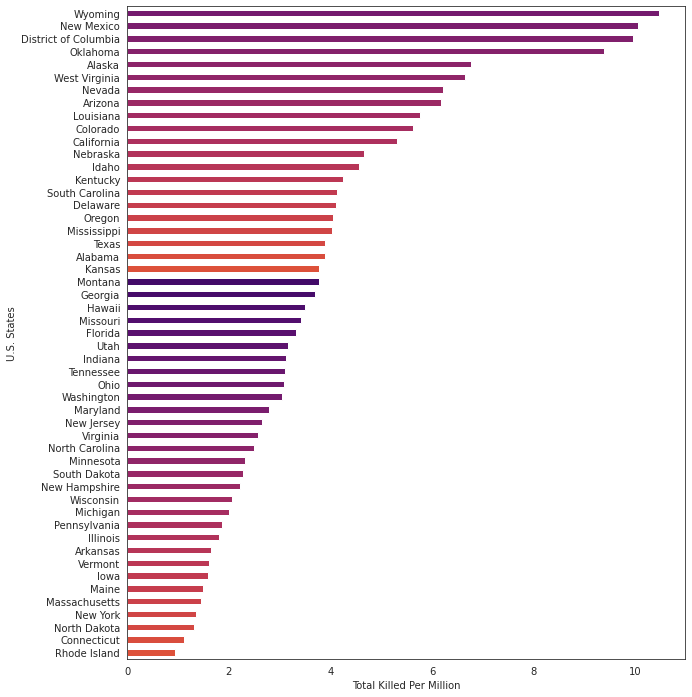

In [66]:
total_killed = deaths_merged.groupby(["state_full", "2018 Population"])["state_full"].count().sort_values(ascending = False).reset_index(name = "count")
total_killed['per_capita'] = (total_killed['count'] / total_killed['2018 Population']) * 1000000
total_killed = total_killed.sort_values(by = 'per_capita', ascending = True)

from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))
sns.set_style("white")
per_capita_killed = total_killed.plot(x = 'state_full', y = 'per_capita', kind = 'barh', figsize = (10, 12), color = color, legend = False)
per_capita_killed.set(xlabel = 'Total Killed Per Million', ylabel = 'U.S. States');